In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection  import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
%matplotlib inline

# Objective

This data set from Kaggle contains tweets about COVID19 vaccines with lists of Hashtags. The goal of this project is classifying these tweets to distinguish health-oriented, political and superstition based on NLP algorithms.

In order to achieve this, we follow three steps:

    1.	Text processing and data preparation: in this step we format the data, delete GDPR related information, extract links from tweets and checking some data features
    
    2.	Assigning categories: this is manual process which plays a role in the prediction quality. We have to classify the tweets directly one-by-one, which is a time-consuming process:
        
    
    Approval                  | 230 | % 7.72 
    Business                  | 50  | % 1.68 
    Health                    | 127 | % 4.26 
    Junk Knowledge            | 224 | % 7.52 
    Other                     | 204 | % 6.85 
    Politics                  | 154 | % 5.17 
    Procurement and Logistics | 231 | % 7.76 
    Unique vaccination        | 780 | % 26.19 
    Vaccination campaign      | 418 | % 14.04 
    Vaccine                   | 400 | % 13.43 
    Side effects              | 160 | % 5.37 

    DISCLAIMER: these classifications are the result of a manual effort whithout medical proper knowledge. Medical professionals     may have a different opinion.

    3.	Once categories are assigned, an NLP vectorizer is used to predict the tweets.

At the end will have a classifier to predict whether the tweet has real informative value in regards to COVID19 and helps to eliminate all junk-science or any other irrelevant information.


## 1. Data Pre-processing

In [2]:
# Read data
twitter_data = pd.read_excel('vaccination_tweets.xlsx',sheet_name='vaccination_tweets')

In a first steps all countries were normalised as a potential feature, for the moment the geographical location is not used:

In [3]:
twitter_data['Country'].fillna('NA',inplace=True)
nb_countries = len(twitter_data['Country'].unique())
freq=pd.DataFrame(twitter_data['Country'].value_counts())
freq.reset_index(inplace=True)
freq.columns = ['Country','Country_freq']
twitter_data  = twitter_data.merge(freq,how='left',on='Country')

The text contains both the tweet and the link to this tweet, we separate both in order to (1) remove noise made by the link (2) make it easier later to check the tweets:

In [4]:
def link_extractor(text):
    if '¦' in text:
        return text.split('¦')[1].strip()
    else:
        return ""

def text_extractor(text):
    if '¦' in text:
        return text.split('¦')[0].strip()
    else:
        return text.strip()

twitter_data['link'] = twitter_data['text'].apply(lambda t:link_extractor(t))
#twitter_data['text'] = twitter_data['text'].apply(lambda t:text_extractor(t))

The table contains data related to the users. As we do not need these columns, it is better to get rid of these data for privacy reasons:

In [5]:
#GDPR filters
del twitter_data['id']
del twitter_data['user_name']
del twitter_data['user_description']

## 2. Assigning Categories

The second step is reading all manually classified values and inserting them into a new column.
To date, 60% of the tweets are classified.

In [6]:
cat = pd.DataFrame(pd.read_excel('vaccination_tweets_processed.xlsx',sheet_name='data processed')['Category'].fillna(''),columns =['Category'])
twitter_data = pd.concat([twitter_data,cat],axis=1)

In [7]:
twitter_data['Category'].unique()

array(['Junk Knowledge', 'Procurement and Logistics', 'Vaccine', 'Health',
       'Politics', 'Vaccination campaign', 'Business', 'Other',
       'Approval', 'Unique vaccination', 'Side effects'], dtype=object)

## 3. NLP Classification

The firstr step is filtering out unclassified or undesired categories:

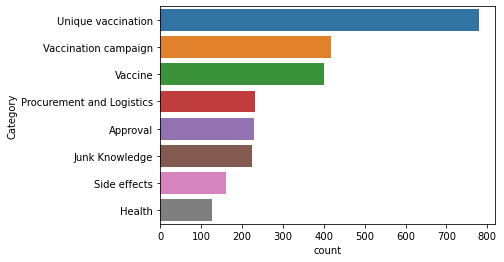

In [8]:
# Deleting Unclassified and 'Other' tweets
twitter_data_sample = twitter_data.copy()
twitter_data_sample = twitter_data_sample[twitter_data_sample['Category'] != '']
twitter_data_sample = twitter_data_sample[twitter_data_sample['Category'] != 'Other']
twitter_data_sample = twitter_data_sample[twitter_data_sample['Category'] != 'Business']
twitter_data_sample = twitter_data_sample[twitter_data_sample['Category'] != 'Politics']
twitter_data_sample.reset_index(inplace = True)
del twitter_data_sample['index']
ax = sns.countplot(y="Category", data=twitter_data_sample, order = twitter_data_sample['Category'].value_counts().index)


In [9]:
def text_cleaner(text):
    """ This function aims at removing links, tagged names and and '#' characters from the text values as they
    do not have real value and add noise to the text
    """
    new_text = []
    text = text.split(' ')
    for element in text:
        add_text = True
        if 'https' in element:
            add_text = False
        if '@' in element:
            add_text = False
        if '#' in element:
            add_text = False
        if add_text:
            new_text.append(element)
    return ' '.join(new_text)

twitter_data_sample['text'] = twitter_data_sample['text'].apply(lambda s:text_cleaner(s))
twitter_data_sample

,user_location,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Country,Country_freq,link,Category
0,"La Crescenta-Montrose, CA",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,United States,610,,Junk Knowledge
1,"San Francisco, CA",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,United States,610,https://t.co/dlCHrZjkhm,Procurement and Logistics
2,Your Bed,2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,Russian vaccine is created to last 2-4 yearsâ€¦,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,NA,827,https://t.co/ieYlCKBr8P,Vaccine
3,"Vancouver, BC - Canada",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,Canada,156,https://t.co/jqgV18kch4,Vaccine
4,NaN,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,NA,827,https://t.co/KxbSRoBEHq,Junk Knowledge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,ðŸŒ,2019-09-23 14:10:22,13,46,920,False,2021-01-02 23:02:32,,"['oxfordastrazeneca', 'PfizerBioNTech', 'Pfize...",Twitter for Android,0,3,False,NA,827,https://t.co/A6VUF9BTW2,Vaccination campaign
2566,Everywhere,2021-01-02 22:28:50,16,121,0,False,2021-01-02 22:36:45,Countries that have approved the COVID-19 vacc...,['PfizerBioNTech'],Twitter for iPhone,0,0,False,NA,827,Canada\nðŸ‡²ðŸ‡½ Mexico\nðŸ‡®ðŸ‡± Israelâ€,Approval
2567,Earth,2018-04-17 03:48:35,22,90,2779,False,2021-01-02 22:20:01,Vaccinated! Got my first dose.,"['PfizerBioNTech', 'vaccine']",Twitter for iPhone,0,2,False,NA,827,,Unique vaccination
2568,NaN,2013-05-06 03:26:53,904,985,12118,False,2021-01-02 22:06:12,OMG congratulations ðŸ˜· ðŸ’‰,"['vaccine', 'PfizerBioNTech']",Twitter for iPhone,0,1,False,NA,827,,Unique vaccination


Defining text filtering function

In [10]:
def text_process(mess):
    """
    1. remove punctuation
    2. remove stop words
    3. return list of cleantext words
    """
    
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Importing NLP libraries:

In [11]:
import nltk
#nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.corpus import stopwords
bow_transformer = CountVectorizer(analyzer = text_process).fit(twitter_data_sample['text'])

Creating the IfIDF matrix

In [12]:
messages_bow = bow_transformer.transform(twitter_data_sample['text'])
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)

Finally, we predict the tweets Category using a MultinomialNB classifier

In [13]:
spam_detect_model = MultinomialNB().fit(messages_tfidf,twitter_data_sample['Category'])
msg_train,msg_test,label_train,label_test = train_test_split(twitter_data_sample['text'],twitter_data_sample['Category'],test_size=0.3)
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer = text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])
pipeline.fit(msg_train,label_train)
precitions = pipeline.predict(msg_test)
print(classification_report(label_test,precitions))


                           precision    recall  f1-score   support

                 Approval       0.93      0.52      0.67        71
                   Health       1.00      0.08      0.15        38
           Junk Knowledge       1.00      0.03      0.05        74
Procurement and Logistics       0.92      0.21      0.34        57
             Side effects       1.00      0.12      0.22        49
       Unique vaccination       0.38      0.98      0.55       238
     Vaccination campaign       0.60      0.25      0.36       127
                  Vaccine       0.61      0.20      0.30       117

                 accuracy                           0.45       771
                macro avg       0.80      0.30      0.33       771
             weighted avg       0.67      0.45      0.39       771



The 'Unique Vaccination' category has lower results than the others, which is due to the fact that a considerable number of these tweets are rather pictures after the vaccination than clear text.

### Some predictions

In [14]:
def predict_value(i):
    """This function takes an index at the table and predict its text category."""
    text = text_cleaner(twitter_data['text'][i])
    cat = twitter_data['Category'][i]
    if cat =="":
        cat = 'Unclassified'
    predict = pipeline.predict([text])[0]
    print("Text:\n----------------------\n{}\n----------------------\nCategory: {}\nPredicted: {}".format(text,cat,predict))

#### Predicting element 50

In [15]:
predict_value(50)

Text:
----------------------
Tragedy. Another life taken by corporate greed and the evil pharmaceutical companies.
----------------------
Category: Junk Knowledge
Predicted: Unique vaccination


#### Predicting element 500

In [16]:
predict_value(400)

Text:
----------------------
COVID-19: New York nurse gets first shots of Coronavirus
----------------------
Category: Unique vaccination
Predicted: Unique vaccination


#### Predicting element 1000

In [17]:
predict_value(1000)

Text:
----------------------
And just like that 1 jab down, 1 to go! Thanks Dr Ammara Hughes for vaccinating me. Helping towards 70% target forâ€¦
----------------------
Category: Unique vaccination
Predicted: Unique vaccination


#### Predicting element 1500

In [18]:
predict_value(1500)

Text:
----------------------
Getting my shot on Wednesday, 11:45 am.  Follow up 3 weeks later!  Thank you.  If I had a request fâ€¦
----------------------
Category: Unique vaccination
Predicted: Unique vaccination


#### Predicting element 2000

In [19]:
predict_value(1800)

Text:
----------------------
Nurse tests positive for despite receiving the
----------------------
Category: Health
Predicted: Unique vaccination
